In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt


from main.models import ConvNet, get_model_constructor
from main.utils import save_experiment
from dataclasses import dataclass
from main.active_learning import run_active_learning
from main.prepare_data import create_dataloaders
from configurations import get_config
from main.utils import load_experiment, load_experiments

%reload_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


In [ ]:
config, experiment_name = get_config(
    method='max_logdet_S',
    min_samples=20,
    max_samples=200,
    acquisition_batch_size=10,
    dataset='repeated_mnist',
    )

experiment_name = 'rep_softlabel'

print(f'Running {experiment_name} experiment')
save_results = True
num_runs = 5

In [ ]:
for i in range(num_runs):

    current_seed = i
    torch.manual_seed(current_seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(current_seed)
        torch.cuda.manual_seed_all(current_seed)

    # load data
    train_loader, test_loader, pool_loader, active_learning_data = create_dataloaders(config)

    print(len(train_loader.dataset), len(test_loader.dataset), len(pool_loader.dataset))
    
    # get results
    results = run_active_learning(
        train_loader=train_loader,
        test_loader=test_loader, 
        pool_loader=pool_loader,
        active_learning_data=active_learning_data,
        model_constructor=get_model_constructor(config.al_method, config.dataset), 
        config=config, 
        device=device
        )

    # save results and configuration
    if save_results:
        experiment_id = experiment_name + '_' + str(i + 1)
        save_experiment(config, results, experiment_id, base_dir='pseudo_label_experiments')
    
    del train_loader, test_loader, pool_loader, active_learning_data

In [11]:
repeated_softlabel_ids = ['pseudo_label_experiments' + '/' + 'rep_softlabel_' + str(i + 1) for i in range(num_runs)]
repeated_hardlabel_ids = ['experiments/max_logdet_S_repeated_mnist_20_to_200_B=10_' + str(i + 1) for i in range(num_runs)]

softlabel_ids = ['pseudo_label_experiments' + '/' + 'softlabel_' + str(i + 1) for i in range(num_runs)]
hardlabel_ids = ['experiments/max_logdet_S_mnist_20_to_200_B=10_' + str(i + 1) for i in range(num_runs)]

dirty_softlabel_ids = ['pseudo_label_experiments' + '/' + 'dirty_softlabel_' + str(i + 1) for i in range(num_runs)]
dirty_hardlabel_ids = ['experiments/max_logdet_S_dirty_mnist_20_to_200_B=10_' + str(i + 1) for i in range(num_runs)]

fashion_softlabel_ids = ['pseudo_label_experiments' + '/' + 'fashion_softlabel_' + str(i + 1) for i in range(num_runs)]
fashion_hardlabel_ids = ['experiments/max_logdet_S_fashion_mnist_20_to_200_B=10_' + str(i + 1) for i in range(num_runs)]

label_experiments = [
    [repeated_softlabel_ids, repeated_hardlabel_ids],
    [softlabel_ids, hardlabel_ids],
    [dirty_softlabel_ids, dirty_hardlabel_ids],
    [fashion_softlabel_ids, fashion_hardlabel_ids]
]

In [36]:
plt.style.use(style='seaborn-v0_8-colorblind')

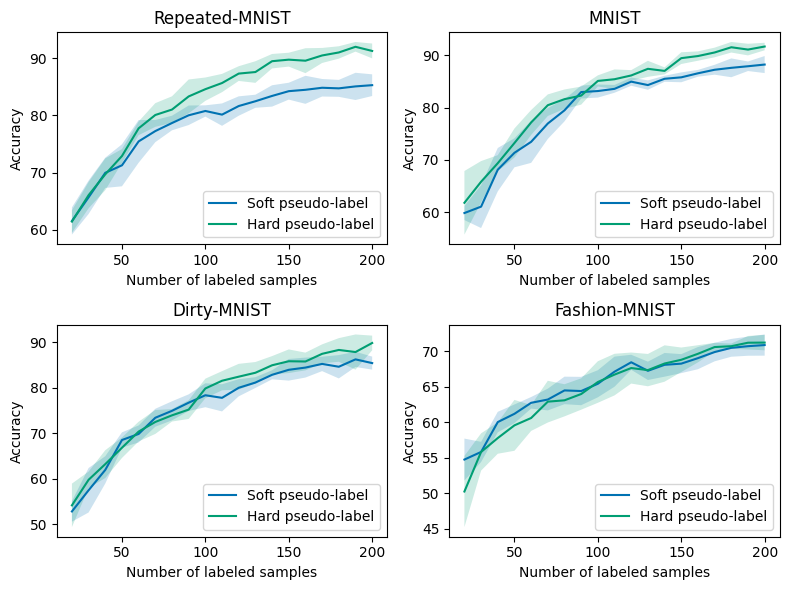

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

for i, method in enumerate(label_experiments):
    for j in range(2):
        results = load_experiments(method[j], base_dir='')
        accuracies = np.array([result[1]['test_accs'] for result in results])
        batch_sizes = np.linspace(20, 200, accuracies.shape[1])

        std = np.std(accuracies, axis=0) / np.sqrt(accuracies.shape[0])
        mean = np.mean(accuracies, axis=0)
        
        # map i from [0, 3] to [0,0], [1,1], [1,0], [0,1]
        idx = (i // 2, i % 2)
        axs[idx].plot(batch_sizes, mean, label='Hard pseudo-label' if j == 1 else 'Soft pseudo-label')
        axs[idx].fill_between(batch_sizes, mean - 1.96*std, mean + 1.96*std, alpha=0.2, label='_nolegend_')

        axs[idx].set_title(['Repeated-MNIST', 'MNIST', 'Dirty-MNIST', 'Fashion-MNIST'][i], fontsize=12)
        axs[idx].set_xlabel('Number of labeled samples', fontsize=10)
        axs[idx].set_ylabel('Accuracy', fontsize=10)
        axs[idx].legend(loc='lower right')
plt.tight_layout()
plt.show()
